# Grid Points Projection

In ECoG datasets the electrodes locations are never the same. For this reason, we establish a grid, a set of points defined in a standardised brain, and interpolate the ECoG locations to this grid such that they are common across patients.

In this notebook, we will plot these grid points and see how the features extracted from our data can be also projected into this grid space.


In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if os.path.basename(SCRIPT_DIR) == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)
from sklearn import metrics, model_selection
from skopt import space as skopt_space
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

## Read BIDS data

For an example with simulated data and/or in a different format, please look into example_SimulatedData

In [3]:
SCRIPT_DIR

'/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples'

In [4]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


## Define the channels

In [5]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=("SQUARED_ROTATION",),
)

In [6]:
nm_channels

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,average,1,0,ecog,good,ECOG_L_1_SMC_AT-avgref
2,ECOG_L_2_SMC_AT,average,1,0,ecog,good,ECOG_L_2_SMC_AT-avgref
3,ECOG_L_3_SMC_AT,average,1,0,ecog,good,ECOG_L_3_SMC_AT-avgref
4,ECOG_L_4_SMC_AT,average,1,0,ecog,good,ECOG_L_4_SMC_AT-avgref
5,ECOG_L_5_SMC_AT,average,1,0,ecog,good,ECOG_L_5_SMC_AT-avgref
6,ECOG_L_6_SMC_AT,average,1,0,ecog,good,ECOG_L_6_SMC_AT-avgref
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_567_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_567_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


## Settings for Feature Estimation

In [7]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

In [8]:
stream.reset_settings()
stream.set_settings_fast_compute()
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': True,
  'raw_normalization': False,
  're_referencing': True,
  'notch_filter': True,
  'preprocessing_order': ['raw_resampling', 'notch_filter', 're_referencing']},
 'features': {'raw_hjorth': False,
  'return_raw': False,
  'bandpass_filter': False,
  'stft': False,
  'fft': True,
  'sharpwave_analysis': False,
  'coherence': False,
  'fooof': False,
  'nolds': False,
  'bursts': False},
 'postprocessing': {'feature_normalization': True,
  'project_cortex': False,
  'project_subcortex': False},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],
  'high beta': [20, 35],

Now we manually set to True the postprocessing 'project_cortex' and 'project_subcortex'.

In [9]:
stream.settings['postprocessing']['project_cortex'] = True
stream.settings['postprocessing']['project_subcortex'] = True

## Feature Estimation
And then we run the analysis:

In [10]:
stream.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

Last batch took: 0.01 seconds
1.0 seconds of data processed
Last batch took: 0.01 seconds
1.1 seconds of data processed
Last batch took: 0.01 seconds
1.2 seconds of data processed
Last batch took: 0.01 seconds
1.3 seconds of data processed
Last batch took: 0.01 seconds
1.4 seconds of data processed
Last batch took: 0.01 seconds
1.5 seconds of data processed
Last batch took: 0.01 seconds
1.6 seconds of data processed
Last batch took: 0.01 seconds
1.7 seconds of 

## Analysing results

In [11]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[0]["name"]

feature_used = (
    "stft" if feature_reader.settings["features"]["stft"] else "fft"
)

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_ECOG_L_1_SMC_AT_fft.png


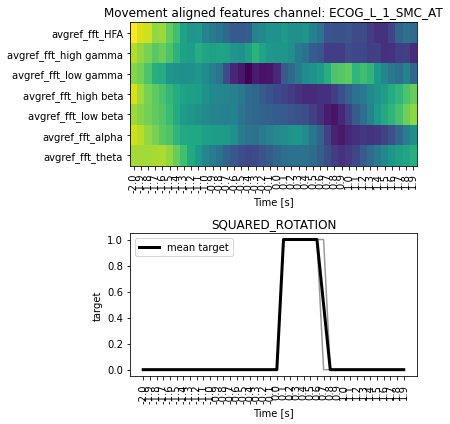

In [12]:
feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

## Grid Projection

When defining our settings, we set in the post-processing step:

```stream.settings['postprocessing']['project_cortex'] = True```
```stream.settings['postprocessing']['project_subcortex'] = True```

This means that we take all the computed features and check for every given grid point if there is any electrode channel in reach. If so, we interpolate for every grid point the channels within the range ```max_dist``` by their respective inverse distance. This gives us a projection matrix that we constantly apply, to go from the feature-channel matrix (n_features, n_channels) to the grid point matrix (n_features, n_gridpoints).

This projection matrix is precomputed (in order to save computation time), and after the feature computation (therefore as a post-processing step) it is applied such that we know the strength of every feature in every grid point. In a scenario where the data is streamed to the pypeline, the feature strength in each grid point is also computed in real time.

The cortical grid is stored in py_neuromodulation/grid_cortex.tsv and the electrodes coordinates (in a BIDS dataset) are stored in "_space-mni_electrodes.tsv".

One remark is that our cortical and subcortical grids are defined for the left hemisphere of the brain and, therefore, in the next steps the electrodes and estimated features are also going to be mapped into the this hemisphere.

From the analyzer, the user can plot the cortical projection with the function below, displaying the grid points as dots and the ECoG electrodes are crosses. The yellow grid points are the ones that are active for that specific ECoG electrode location. The inactive grid points are shown in purple.

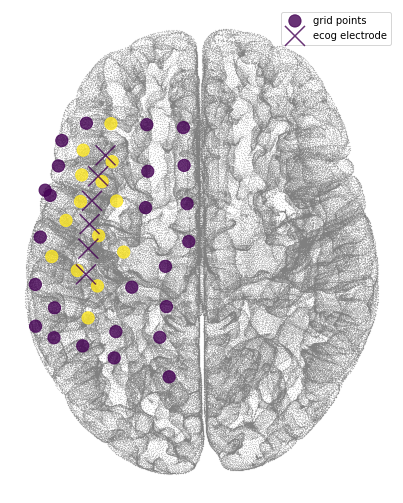

In [13]:
feature_reader.plot_cort_projection()

We can also plot only the ECoG electrodes or the grid points, with the help of the data saved in feature_reader.sidecar. In BIDS sidecar files are json files where you store additional information, here it is used to save the ECoG strip positions and the grid coordinates, which are not part of the settings and nm_channels.csv. We can check what is in the file and then use the nmplotter.plot_cortex function:

In [14]:
feature_reader.sidecar

{'original_fs': 1375.0,
 'sfreq': 1000,
 'sess_right': False,
 'coords': {'cortex_left': {'ch_names': ['ECOG_L_1_SMC_AT',
    'ECOG_L_2_SMC_AT',
    'ECOG_L_3_SMC_AT',
    'ECOG_L_4_SMC_AT',
    'ECOG_L_5_SMC_AT',
    'ECOG_L_6_SMC_AT'],
   'positions': [[-47.0, -26.0, 65.0],
    [-46.0, -15.5, 63.0],
    [-45.5, -5.5, 60.5],
    [-44.5, 4.0, 57.5],
    [-42.0, 14.0, 53.5],
    [-39.0, 22.5, 49.5]]},
  'cortex_right': {'ch_names': [], 'positions': []},
  'subcortex_left': {'ch_names': ['LFP_L_1_STN_BS',
    'LFP_L_234_STN_BS',
    'LFP_L_567_STN_BS'],
   'positions': [[-11.3, -15.9, -9.9],
    [-11.8, -15.0, -7.7],
    [-12.39, -14.29, -5.9]]},
  'subcortex_right': {'ch_names': ['LFP_R_234_STN_BS', 'LFP_R_567_STN_BS'],
   'positions': [[12.93, -13.41, -4.1], [13.4, -12.52, -2.2]]}},
 'grid_cortex': [[-13.1, -67.7, 69.1],
  [-35.5, -60.0, 66.0],
  [-48.3, -55.1, 58.2],
  [-60.0, -51.8, 48.0],
  [-16.9, -51.6, 78.0],
  [-34.8, -49.3, 71.7],
  [-67.5, -47.1, 31.0],
  [-46.1, -43.7, 61.1],

Then we initialize NM_Plot:

__ATENTION: If we initialize NM_Plot with all parameters, then we cant use plot cortex to plot only the ecog_strip or only the cortical grid. Do we want that? Also, why is the color bar named balanced accuracy?__

In [15]:
grid_plotter = nm_plots.NM_Plot(
    ecog_strip=np.array(feature_reader.sidecar["coords"]["cortex_left"]["positions"]),
    grid_cortex=np.array(feature_reader.sidecar["grid_cortex"]),
    grid_subcortex=np.array(feature_reader.sidecar["grid_subcortex"]),
    sess_right=feature_reader.sidecar["sess_right"],
    proj_matrix_cortex=np.array(feature_reader.sidecar["proj_matrix_cortex"]))

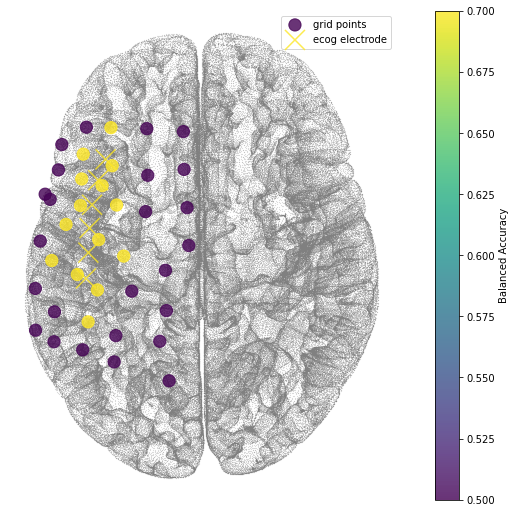

In [16]:
grid_plotter.plot_cortex(grid_color=np.sum(np.array(feature_reader.sidecar["proj_matrix_cortex"]),axis=1))

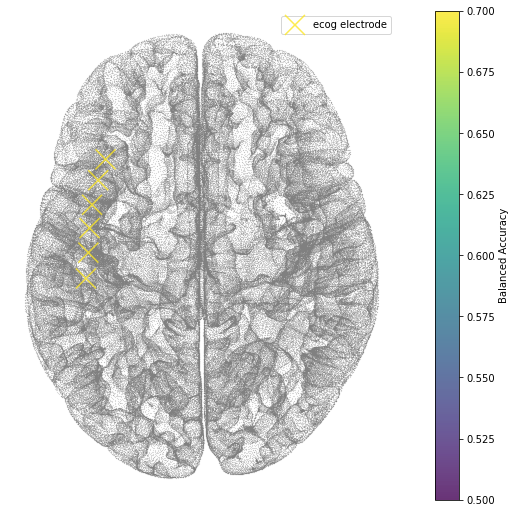

In [17]:
feature_reader.nmplotter.plot_cortex(ecog_strip=np.array(
    feature_reader.sidecar["coords"]["cortex_left"]["positions"],
))

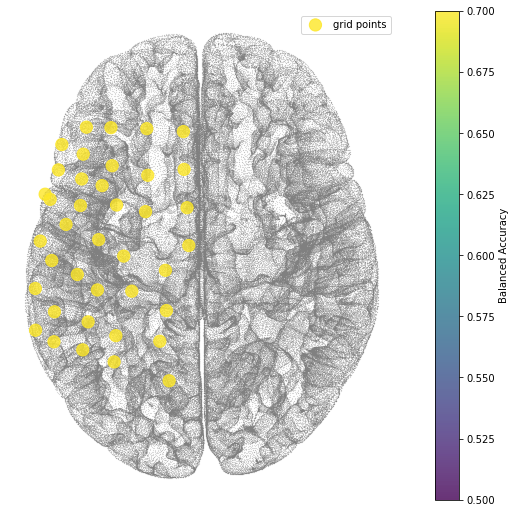

In [18]:
feature_reader.nmplotter.plot_cortex(np.array(
    feature_reader.sidecar["grid_cortex"],

))

FIlter feature data frame and plot as colors, features in the grid.

### Feature Plot in the Grid: An Example of Post-processing

__QUESTION__: Is this what you had in mind?

First I take the dataframe with all the features in all time points.

In [19]:
df = feature_reader.feature_arr

In [20]:
df

,ECOG_L_1_SMC_AT-avgref_fft_theta,ECOG_L_1_SMC_AT-avgref_fft_alpha,ECOG_L_1_SMC_AT-avgref_fft_low beta,ECOG_L_1_SMC_AT-avgref_fft_high beta,ECOG_L_1_SMC_AT-avgref_fft_low gamma,ECOG_L_1_SMC_AT-avgref_fft_high gamma,ECOG_L_1_SMC_AT-avgref_fft_HFA,ECOG_L_2_SMC_AT-avgref_fft_theta,ECOG_L_2_SMC_AT-avgref_fft_alpha,ECOG_L_2_SMC_AT-avgref_fft_low beta,...,gridsubcortex_879_fft_high gamma,gridsubcortex_891_fft_high gamma,gridsubcortex_1082_fft_high gamma,gridsubcortex_866_fft_HFA,gridsubcortex_878_fft_HFA,gridsubcortex_879_fft_HFA,gridsubcortex_891_fft_HFA,gridsubcortex_1082_fft_HFA,time,SQUARED_ROTATION
0,2.514860,2.403410,2.198776,1.998523,1.553934,1.293263,1.135885,2.449370,2.370808,2.198713,...,1.243567,1.164196,1.437991,1.266451,1.230457,1.115252,1.047925,1.271730,1000.0,0.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1100.0,0.0
2,0.998421,1.007385,1.011571,1.008333,1.007001,1.041427,1.044621,0.991936,0.995947,1.011555,...,1.028620,1.031002,1.020809,1.032428,1.035808,1.042226,1.044785,1.034029,1200.0,0.0
3,0.819123,0.802955,0.839980,0.843142,0.868784,0.929398,0.944505,0.821625,0.796104,0.836691,...,0.931271,0.946196,0.892919,0.914553,0.924378,0.949324,0.962142,0.916210,1300.0,0.0
4,0.529139,0.492178,0.597496,0.596853,0.672734,0.782669,0.808858,0.553111,0.506525,0.590897,...,0.752187,0.778643,0.689187,0.742900,0.758283,0.798633,0.819806,0.744879,1400.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.401733,0.564153,0.794915,0.776986,0.333523,0.136338,0.281945,0.351023,0.765050,0.852098,...,0.312808,0.384289,0.151955,0.316449,0.332923,0.412344,0.465989,0.301311,17500.0,0.0
166,0.471304,0.662124,0.741468,0.795775,0.351282,0.177083,0.268127,0.471449,0.828874,0.791282,...,0.268369,0.337591,0.106959,0.283161,0.307905,0.390371,0.439450,0.277974,17600.0,0.0
167,0.476390,0.714553,0.680226,0.752912,0.302335,0.230523,0.280660,0.505616,0.827877,0.736026,...,0.240227,0.302263,0.083356,0.253483,0.279747,0.360249,0.406330,0.251328,17700.0,0.0
168,0.549206,0.793910,0.640914,0.739571,0.298216,0.324227,0.347502,0.598678,0.870130,0.684848,...,0.209015,0.260479,0.070616,0.220547,0.250011,0.336212,0.384393,0.220088,17800.0,0.0


Then we filter for only 'avgref_fft_theta', which gives us the value for fft_theta in all 6 ECoG channels over all time points. Then I take only the 6th time point - as an arbitrary choice.

In [21]:
fft_theta_oneTimePoint = np.asarray(df[df.columns[df.columns.str.contains(pat = 'avgref_fft_theta')]].iloc[5])

Then the projection of the features into the grid is gonna be the color of the grid points in the plot_cortex function. That is, what I call color is the matrix multiplication of the projection matrix of the cortex and the 6 values for the fft_theta feature above.

In [22]:
grid_fft_Theta = np.array(feature_reader.sidecar["proj_matrix_cortex"]) @ fft_theta_oneTimePoint

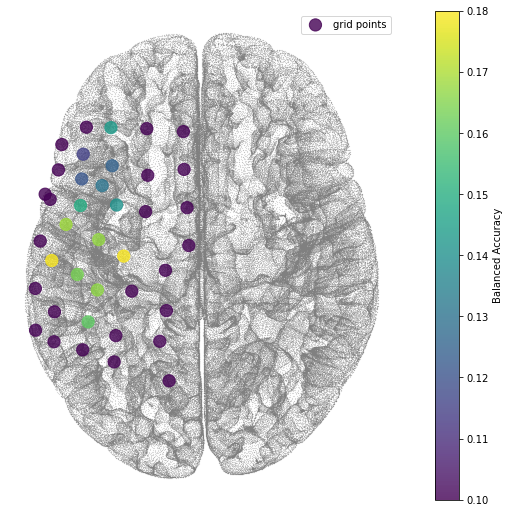

In [23]:
feature_reader.nmplotter.plot_cortex(np.array(
    feature_reader.sidecar["grid_cortex"]),grid_color = grid_fft_Theta, set_clim = True, lower_clim=0.1, upper_clim=0.18)

Lower and upper boundaries for clim were chosen by visually inspecting the values of the projection of the features.

In [24]:
grid_fft_Theta

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16023154, 0.        , 0.        ,
       0.        , 0.16651104, 0.        , 0.16351235, 0.        ,
       0.17932512, 0.17932512, 0.        , 0.        , 0.16695673,
       0.16832827, 0.        , 0.        , 0.14936393, 0.14045773,
       0.        , 0.        , 0.13083728, 0.12134317, 0.        ,
       0.        , 0.        , 0.12490396, 0.11527445, 0.        ,
       0.        , 0.        , 0.14348665, 0.        ])

In the plot above we can see how the intensity of the fast fourier transform in the theta band varies for each grid point in the cortex, for one specific time point.